In [2]:
#implementação do circuito de adição proposto por Vedral, Barenco e Ekert, utilizando 3n bits, onde n é número de bits de cada operando

import qiskit

n = 2

qc = qiskit.QuantumCircuit(3*n + 1)

In [ ]:
#qc_carry function recieves a 4 qubit circuit (carryIn, a, b, carryOut) sets the carry out value accondingly for the sum of a,b,carryIn
#qubits is a list with the index of the operands
def qc_carry(quantum_circuit: qiskit.QuantumCircuit, qubits: list[int]) -> qiskit.QuantumCircuit:
    quantum_circuit.ccx(qubits[1], qubits[2], qubits[3]) 
    quantum_circuit.cx(qubits[1], qubits[2]) 
    quantum_circuit.ccx(qubits[0], qubits[2], qubits[3]) 
    return quantum_circuit

def qc_carry2() -> qiskit.QuantumCircuit:
    cIn = qiskit.QuantumRegister(1, name="cIn")
    a = qiskit.QuantumRegister(1, name="a")
    b = qiskit.QuantumRegister(1, name="b")
    cOut = qiskit.QuantumRegister(1, name="cOut")
    quantum_circuit = qiskit.QuantumCircuit(cIn, a, b, cOut)

    quantum_circuit.ccx(1, 2, 3)
    quantum_circuit.cx(1, 2)
    quantum_circuit.ccx(0, 2, 3)

    return quantum_circuit

#qc = qc_carry(qc, [0,1,2,3])

#inv_qc_carry is the inverse/reversed version of qc_carry
def inv_qc_carry(quantum_circuit: qiskit.QuantumCircuit, qubits: list[int]) -> qiskit.QuantumCircuit:
    quantum_circuit.ccx(qubits[0], qubits[2], qubits[3]) 
    quantum_circuit.cx(qubits[1], qubits[2]) 
    quantum_circuit.ccx(qubits[1], qubits[2], qubits[3]) 
    return quantum_circuit

#qc.draw(output=	"mpl")

In [16]:
#qc_sum function recieves a 3 qubit quantum circuit (a, b, s) and sets the value of s according to the result of the sum from a and b
#qubits is a list with the index of the operands
def qc_sum(quantum_circuit: qiskit.QuantumCircuit, qubits: list[int]) -> qiskit.QuantumCircuit:
    quantum_circuit.cx(qubits[1], qubits[2])
    quantum_circuit.cx(qubits[0], qubits[2])
    return quantum_circuit

def qc_sum2() -> qiskit.QuantumCircuit:
    c = qiskit.QuantumRegister(1, name="c")
    a = qiskit.QuantumRegister(1, name="a")
    b = qiskit.QuantumRegister(1, name="b")
    quantum_circuit = qiskit.QuantumCircuit(c, a, b)
    quantum_circuit.cx(1,2)
    quantum_circuit.cx(0,2)
    return quantum_circuit

#qc = qc_sum(qc, [0,1,2])

#inv_qc_sum is the inverse/reversed version of qc_sum
def inv_qc_sum(quantum_circuit: qiskit.QuantumCircuit, qubits: list[int]) -> qiskit.QuantumCircuit:
    quantum_circuit.cx(qubits[0], qubits[2])
    quantum_circuit.cx(qubits[1], qubits[2])
    return quantum_circuit


#qc.draw(output="mpl")

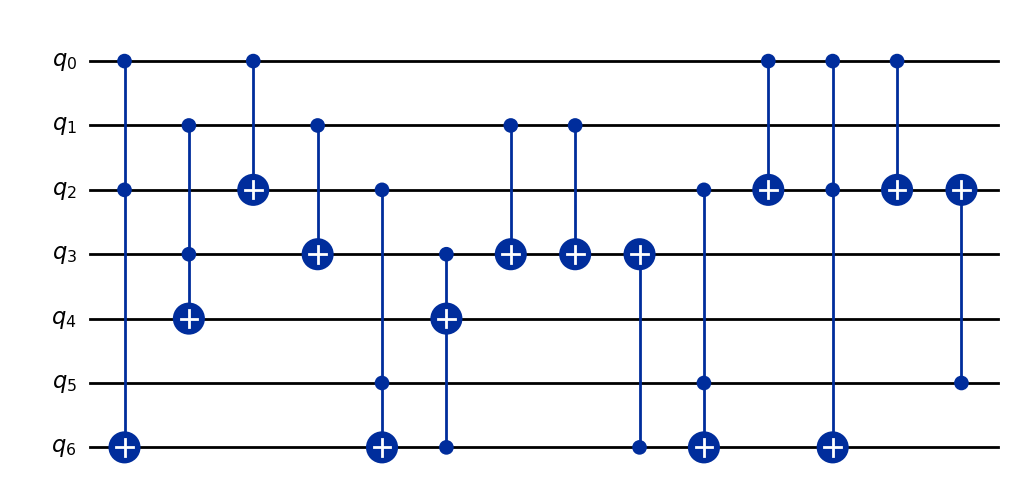

In [5]:
#qc_adder funcion implements the adder circuit, (a,b) -> (a,a+b) using 3n bits, n = number of bits for each operand, operand b has an extra 0 bit to hold the final carry
#first n bits are from operand a, next n bits from b, the rest are work bits c
def qc_adder(quantum_circuit: qiskit.QuantumCircuit, n: int) -> qiskit.QuantumCircuit:
    for i in range(n):
        quantum_circuit = qc_carry(quantum_circuit, [2*n+1+i, i, n+i, 2*n+2+i if i != n-1 else 2*n])
    quantum_circuit.cx(n-1, 2*n-1)
    quantum_circuit = qc_sum(quantum_circuit, [3*n, n-1, 2*n-1])
    for i in range(n-1):
        quantum_circuit = inv_qc_carry(quantum_circuit, [3*n-1-i, n-2-i, 2*n-2-i, 3*n-i])
        quantum_circuit = qc_sum(quantum_circuit, [3*n-1-i, n-2-i, 2*n-2-i])
    return quantum_circuit
qc = qc_adder(qc, n)
qc.draw(output="mpl")

In [6]:
from qiskit.quantum_info import Statevector
test_n = 3
test_circ = qiskit.QuantumCircuit(3*test_n + 1)
test_circ = qc_adder(test_circ,test_n)
#test_circ.draw("mpl")
Statevector.from_label("0000110101").evolve(test_circ).draw("latex")

<IPython.core.display.Latex object>

In [7]:
Statevector.from_label("0000100100").evolve(test_circ.inverse()).draw("latex")

<IPython.core.display.Latex object>

In [8]:
def qc_adder2(a: qiskit.QuantumRegister, b: qiskit.QuantumRegister, c: qiskit.QuantumRegister, n: int) -> qiskit.QuantumCircuit:

    quantum_circuit = qiskit.QuantumCircuit(a,b,c)

    for i in range(n):
        quantum_circuit = qc_carry(quantum_circuit, [2*n+1+i, i, n+i, 2*n+2+i if i != n-1 else 2*n])
    quantum_circuit.cx(n-1, 2*n-1)
    quantum_circuit = qc_sum(quantum_circuit, [3*n, n-1, 2*n-1])
    for i in range(n-1):
        quantum_circuit = inv_qc_carry(quantum_circuit, [3*n-1-i, n-2-i, 2*n-2-i, 3*n-i])
        quantum_circuit = qc_sum(quantum_circuit, [3*n-1-i, n-2-i, 2*n-2-i])
    return quantum_circuit


In [9]:
#returns a list with the indexes of all qubits in qregs
def get_qubits(qc: qiskit.QuantumCircuit, qregs: list[qiskit.QuantumRegister]) -> list[int]:
    bits = []
    for qreg in qregs:
        n = qc.find_bit(qreg[0]).index
        bits.extend(list(range(n, n+qreg.size)))
    return bits

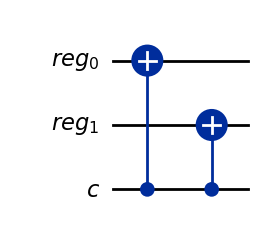

In [10]:
#applies a not in all bits of a given register acconding to control bit
def cx_reg(num_qubits: int) -> qiskit.QuantumCircuit:
    reg = qiskit.QuantumRegister(num_qubits, name="reg")
    c = qiskit.QuantumRegister(1, name="c")
    qc = qiskit.QuantumCircuit(reg,c)
    for qubit in reg:
        qc.cx(c[0], qubit)
    return qc

cx_reg(2).draw("mpl")

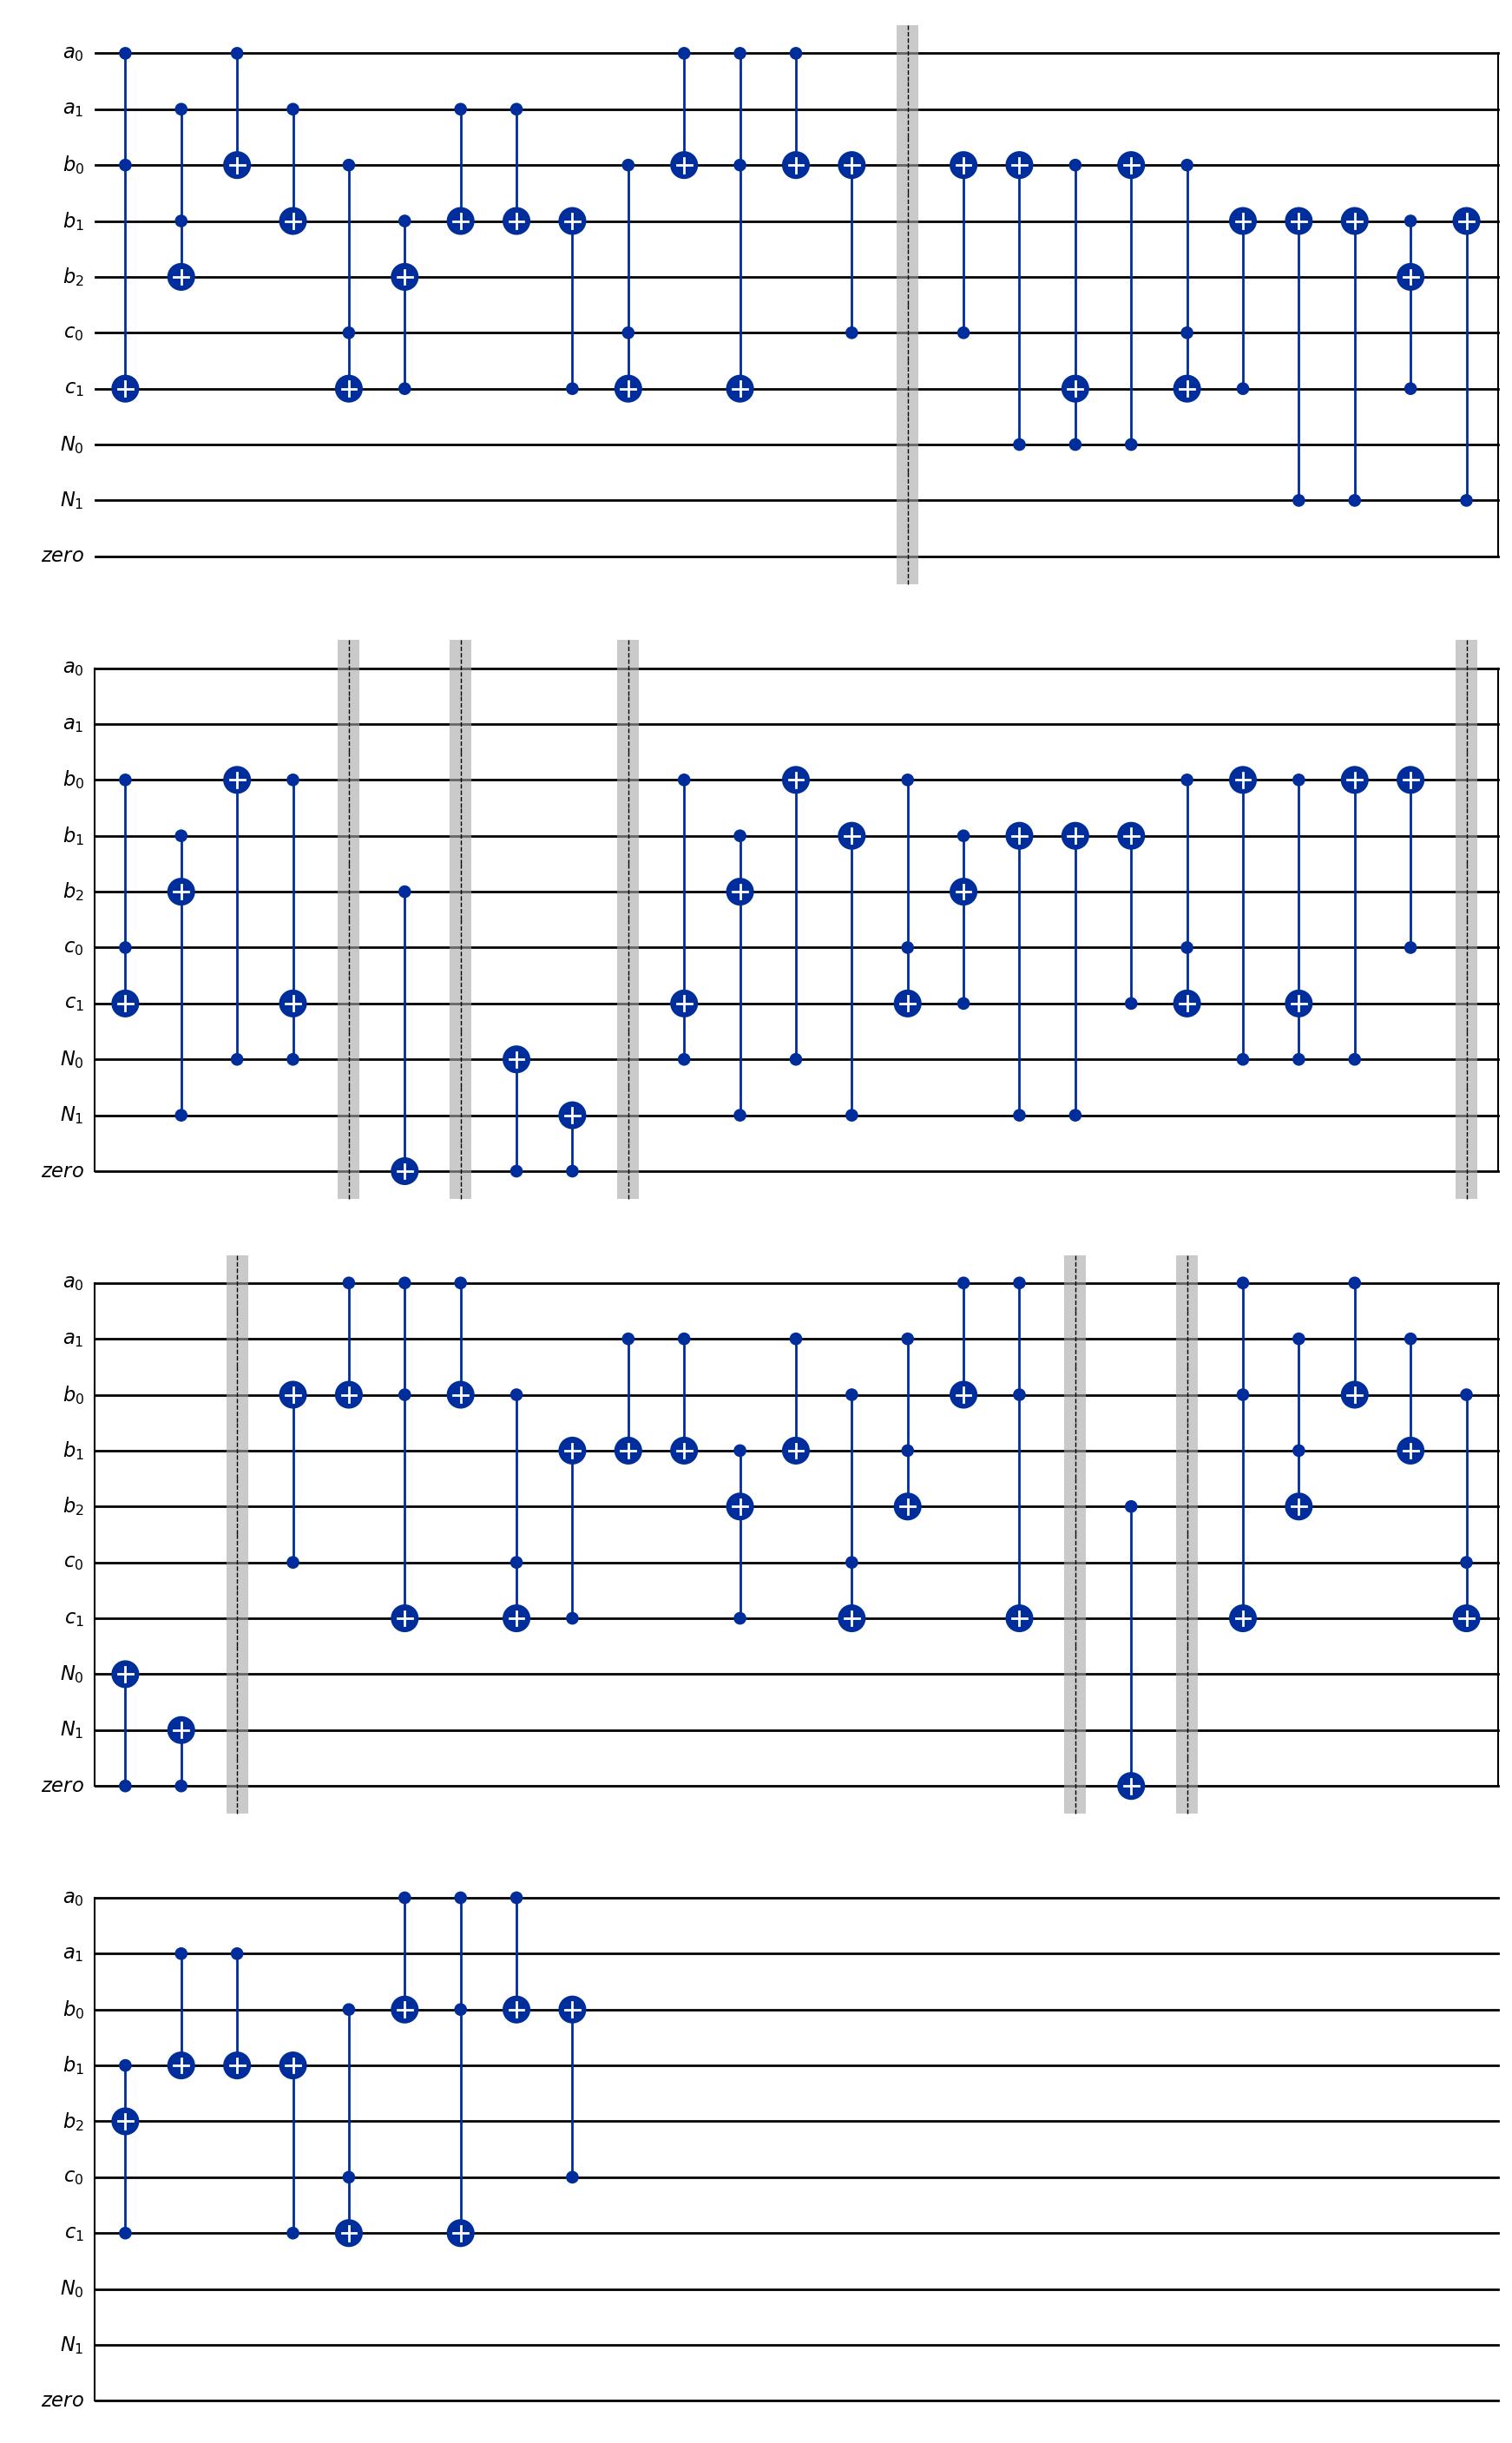

In [ ]:
def mod_adder(num_qubits: int) -> qiskit.QuantumCircuit:
    #init work qubits and circuit
    zero = qiskit.QuantumRegister(1, name="zero")
    a = qiskit.QuantumRegister(num_qubits, name="a")
    b = qiskit.QuantumRegister(num_qubits + 1, name="b")
    c = qiskit.QuantumRegister(num_qubits, name="c")
    n = qiskit.QuantumRegister(num_qubits, name="N")
    quantum_circuit = qiskit.QuantumCircuit(a, b, c, n, zero)
    
    #defining circs
    adder_circ = qc_adder(qiskit.QuantumCircuit(3*num_qubits + 1), num_qubits)
    cx_reg_circ = cx_reg(num_qubits)

    #(a,b) -> (a, a+b)
    quantum_circuit.compose(adder_circ, qubits=get_qubits(quantum_circuit, [a,b,c]), inplace=True)

    quantum_circuit.barrier()
    #(N,a+b) -> (N, a+b-N)
    quantum_circuit.compose(adder_circ.inverse(), qubits=get_qubits(quantum_circuit, [n,b,c]), inplace=True)

    quantum_circuit.barrier()

    quantum_circuit.cx(b[-1], zero[0])

    quantum_circuit.barrier()

    quantum_circuit.compose(cx_reg_circ, qubits=get_qubits(quantum_circuit, [n,zero]), inplace=True)

    quantum_circuit.barrier()

    quantum_circuit.compose(adder_circ, qubits=get_qubits(quantum_circuit, [n,b,c]), inplace=True)

    quantum_circuit.barrier()

    quantum_circuit.compose(cx_reg_circ, qubits=get_qubits(quantum_circuit, [n,zero]), inplace=True)

    quantum_circuit.barrier()

    quantum_circuit.compose(adder_circ.inverse(), qubits=get_qubits(quantum_circuit, [a,b,c]), inplace=True)

    quantum_circuit.barrier()

    quantum_circuit.cx(b[-1], zero[0])
    
    quantum_circuit.barrier()

    quantum_circuit.compose(adder_circ, qubits=get_qubits(quantum_circuit, [a,b,c]), inplace=True)
    return quantum_circuit

mod_adder(2).draw("mpl")

In [12]:
Statevector.from_label("0010001111").evolve(mod_adder(2)).draw("latex")

<IPython.core.display.Latex object>

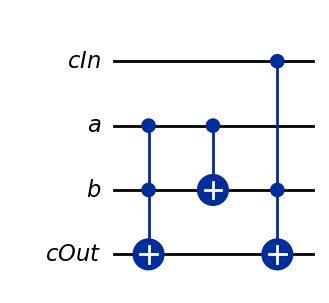

In [13]:
qc_carry2().draw("mpl")

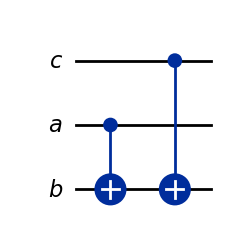

In [17]:
qc_sum2().draw("mpl")